# NREL - Offshore WA OR - turbine: 25915

## Predicción: h = 1 / H = 24

## Mo Decision Tree Regressor

**Parámetros:**

* criterion:
 
* splitter:

* max_depth:

* min_samples_split:

* min_samples_leaf:

* min_weight_fraction_leaf:

* max_features:

* random_state:

* max_leaf_nodes:

* min_impurity_decrease:

* min_impurity_split:

* presort:

In [33]:
%matplotlib inline
import os
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# import RenewAI
sys.path.append('/Users/tmorales/tmp/RNN-windPower/src')
from pre_process.split_ml_ts import dataframe_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics.regression import mean_absolute_error
from sklearn.metrics.regression import mean_squared_error
from sklearn.externals import joblib

In [3]:
exp_path = '/Users/tmorales/tmp/experiments/NREL/Offshore_WA_OR/turbine_25915'
experiment_name = 'nn-fully-connect-one-hidden'
directory = os.path.join(exp_path, experiment_name)
if not os.path.exists(directory):
    os.makedirs(directory)

## Load file

In [4]:
path = '/Users/tmorales/tmp/RNN-windPower/database/wind_farms/Offshore_WA_OR/Offshore_WA_OR_features'

In [5]:
os.chdir(path)
files = [file for file in glob.glob('Offshore_WA_OR_features_*.csv')]
files

['Offshore_WA_OR_features_h_01.csv',
 'Offshore_WA_OR_features_h_02.csv',
 'Offshore_WA_OR_features_h_03.csv',
 'Offshore_WA_OR_features_h_04.csv',
 'Offshore_WA_OR_features_h_05.csv',
 'Offshore_WA_OR_features_h_06.csv',
 'Offshore_WA_OR_features_h_07.csv',
 'Offshore_WA_OR_features_h_08.csv',
 'Offshore_WA_OR_features_h_09.csv',
 'Offshore_WA_OR_features_h_10.csv',
 'Offshore_WA_OR_features_h_11.csv',
 'Offshore_WA_OR_features_h_12.csv',
 'Offshore_WA_OR_features_h_13.csv',
 'Offshore_WA_OR_features_h_14.csv',
 'Offshore_WA_OR_features_h_15.csv',
 'Offshore_WA_OR_features_h_16.csv',
 'Offshore_WA_OR_features_h_17.csv',
 'Offshore_WA_OR_features_h_18.csv',
 'Offshore_WA_OR_features_h_19.csv',
 'Offshore_WA_OR_features_h_20.csv',
 'Offshore_WA_OR_features_h_21.csv',
 'Offshore_WA_OR_features_h_22.csv',
 'Offshore_WA_OR_features_h_23.csv',
 'Offshore_WA_OR_features_h_24.csv']

## Paso 1: only one h-step

In [6]:
h1 = files[0]

In [30]:
# create directory for each horizont (each horizon is a regressor)
horizont = 1
directory_by_horizont = os.path.join(exp_path, 
                                     'decision_tree_regressor',
                                     'model_saved_h={0:03d}'.format(horizont))
if not os.path.exists(directory_by_horizont):
    os.makedirs(directory_by_horizont)

In [7]:
# create directory for each horizont (each horizon is a regressor)
horizont = 1
directory_by_horizont = os.path.join(exp_path, 
                                     experiment_name,
                                     'model_saved_h={0:03d}'.format(horizont))
if not os.path.exists(directory_by_horizont):
    os.makedirs(directory_by_horizont)

In [8]:
# load file
df_h1 = pd.read_csv(files[0], delimiter=';', index_col=0)
df_h1.head(4)

,f_0,f_1,f_2,f_3,f_4,f_5,target_h1
target_date,,,,,,,
2004-01-01 06:00:00,6.96,5.28,5.32,4.93,4.05,3.95,4.19
2004-01-01 07:00:00,5.28,5.32,4.93,4.05,3.95,4.19,4.89
2004-01-01 08:00:00,5.32,4.93,4.05,3.95,4.19,4.89,5.16
2004-01-01 09:00:00,4.93,4.05,3.95,4.19,4.89,5.16,5.01


In [9]:
# select the best model for h=1

# split the dataset in train, val and test
data = dataframe_split(df_h1)
train_set = data['train_set']
validation_set = data['validation_set']
test_set = data['test_set']

In [10]:
# features and target columns
features_columns = train_set.columns[1:-1]
target_column = train_set.columns[-1:]

In [21]:
# select the values of features and target columns.
features_train_set = train_set[features_columns]
target_train_set = train_set[target_column]
features_validation_set = validation_set[features_columns]
target_validation_set = validation_set[target_column]
features_test_set = test_set[features_columns]
target_test_set = test_set[target_column]

In [12]:
print('features columns: {0}'.format(features_columns))
print('target column: {0}'.format(target_column))

features columns: Index(['f_1', 'f_2', 'f_3', 'f_4', 'f_5'], dtype='object')
target column: Index(['target_h1'], dtype='object')


In [13]:
x_train = features_train_set.values; y_train = target_train_set.values
x_val = features_validation_set.values; y_val = target_validation_set.values

## Paso 2: Model defenition

In [34]:
# select best model
max_depth = 40

history = {} # dictionary with all metrics
mse = [] ; val_mse = [] # mean squared error
max_depth_range = range(2, max_depth, 2 )

for m_depth in max_depth_range:
    print('*** Max depth: {0}'.format(m_depth))
    # - model parameters
    dtr = DecisionTreeRegressor(
        criterion="mse",
        splitter="best",
        max_depth=m_depth,
        min_samples_split=2,
        min_samples_leaf=1)
    # - fit the data 
    dtr = dtr.fit(x_train, y_train)
    # - save del model
    path_model_saved = os.path.join(directory_by_horizont, 
                                    'decision_tree_{0:03d}'.format(m_depth))
    joblib.dump(dtr, path_model_saved)
    # - overfitting: evaluate train and validation set on the fitted model. 
    y_train_eval = dtr.predict(x_train)
    y_val_eval = dtr.predict(x_val)
    # - metric calculation
    mse_train = mean_squared_error(y_train, y_train_eval)
    mse_validation = mean_absolute_error(y_val, y_val_eval)
    # for each depp confoguration save the metrics inside a list 
    mse.append(mse_train); val_mse.append(mse_validation)

history['mse'] = mse
history['val_mse'] = val_mse

*** Max depth: 2
*** Max depth: 4
*** Max depth: 6
*** Max depth: 8
*** Max depth: 10
*** Max depth: 12
*** Max depth: 14
*** Max depth: 16
*** Max depth: 18
*** Max depth: 20
*** Max depth: 22
*** Max depth: 24
*** Max depth: 26
*** Max depth: 28
*** Max depth: 30
*** Max depth: 32
*** Max depth: 34
*** Max depth: 36
*** Max depth: 38


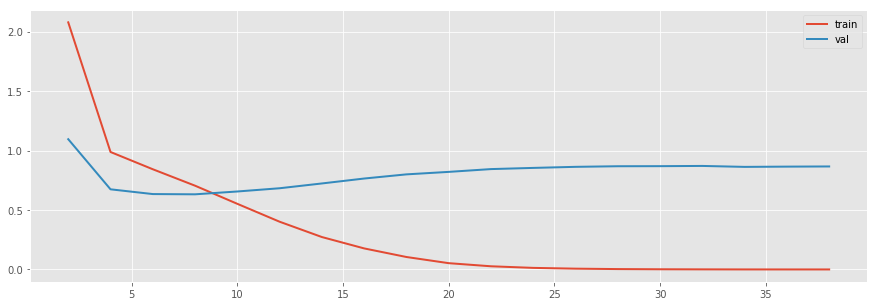

In [15]:
f = plt.figure(figsize=(15, 5))
plt.plot(max_depth_range, history['mse'], lw=2, label='train')
plt.plot(max_depth_range, history['val_mse'], lw=2, label='val')
plt.legend()

## Paso 3: Prediction

In [24]:
x_test = features_test_set.values.astype('float32')
x_test_lstm = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test_lstm.shape

(5260, 5, 1)

In [37]:
best_model = os.path.join(directory_by_horizont, 'decision_tree_008')
model = joblib.load(best_model)
model

DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [39]:
predicted = model.predict(x_test)

In [40]:
df_prediction = test_set.copy()
df_prediction.head()

,f_0,f_1,f_2,f_3,f_4,f_5,target_h1
target_date,,,,,,,
2006-05-26 20:00:00,5.30,5.19,5.24,5.27,4.45,3.92,4.19
2006-05-26 21:00:00,5.19,5.24,5.27,4.45,3.92,4.19,4.60
2006-05-26 22:00:00,5.24,5.27,4.45,3.92,4.19,4.60,5.34
2006-05-26 23:00:00,5.27,4.45,3.92,4.19,4.60,5.34,4.70
2006-05-27 00:00:00,4.45,3.92,4.19,4.60,5.34,4.70,3.00


In [41]:
df_prediction['target_predicted'] = predicted
df_prediction.head()

,f_0,f_1,f_2,f_3,f_4,f_5,target_h1,target_predicted
target_date,,,,,,,,
2006-05-26 20:00:00,5.30,5.19,5.24,5.27,4.45,3.92,4.19,3.666258
2006-05-26 21:00:00,5.19,5.24,5.27,4.45,3.92,4.19,4.60,4.617167
2006-05-26 22:00:00,5.24,5.27,4.45,3.92,4.19,4.60,5.34,4.553725
2006-05-26 23:00:00,5.27,4.45,3.92,4.19,4.60,5.34,4.70,5.687908
2006-05-27 00:00:00,4.45,3.92,4.19,4.60,5.34,4.70,3.00,4.553725


In [42]:
# save test dataframe (df_prediction)
filename =  os.path.join(directory_by_horizont, experiment_name)
df_prediction.to_csv('{0}.csv'.format(filename))

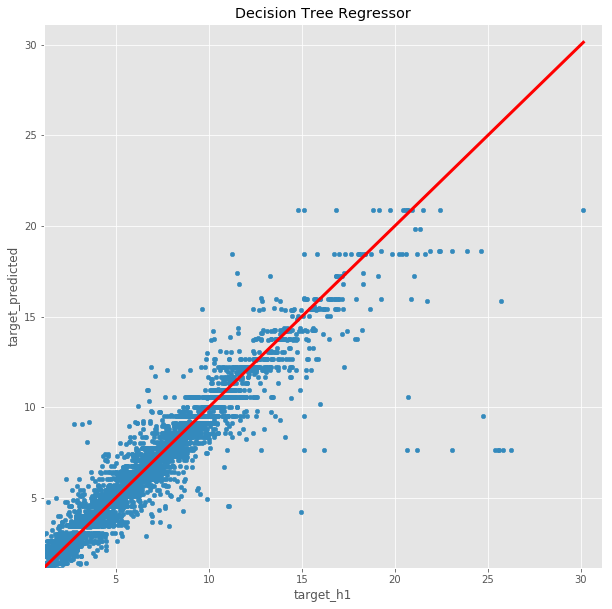

In [43]:
#title='LSTM-10-unit_hidden-5'
title='Decision Tree Regressor'

f, ax = plt.subplots(1,1,figsize=(10,10))
x_min = df_prediction.target_h1.min() 
x_max = df_prediction.target_h1.max()
y_min = df_prediction.target_predicted.min()
y_max = df_prediction.target_predicted.max()
ax.set_title(title)
# line
ax.set_xlim(x_min+1, x_max+1)
ax.set_ylim(x_min+1, x_max+1)
ax.plot((x_min, x_max), (x_min, x_max), lw=3, c='r')
# scatter
df_prediction.plot(ax=ax,
                   x='target_h1',
                   y='target_predicted',
                   kind='scatter',
                  )

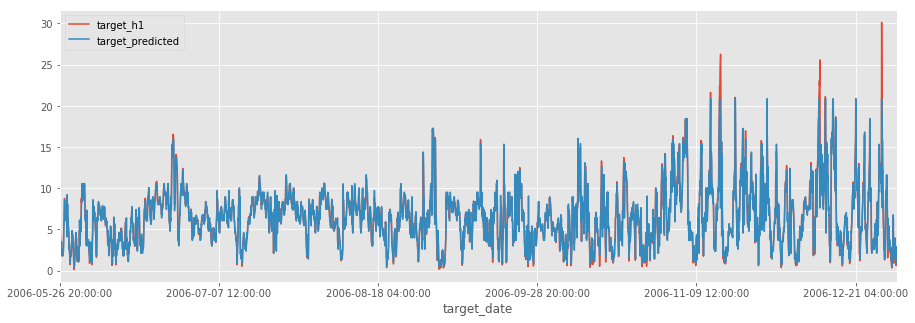

In [44]:
df_prediction.iloc[:,-2:].plot(figsize=(15,5))

In [45]:
df_prediction.head()

,f_0,f_1,f_2,f_3,f_4,f_5,target_h1,target_predicted
target_date,,,,,,,,
2006-05-26 20:00:00,5.30,5.19,5.24,5.27,4.45,3.92,4.19,3.666258
2006-05-26 21:00:00,5.19,5.24,5.27,4.45,3.92,4.19,4.60,4.617167
2006-05-26 22:00:00,5.24,5.27,4.45,3.92,4.19,4.60,5.34,4.553725
2006-05-26 23:00:00,5.27,4.45,3.92,4.19,4.60,5.34,4.70,5.687908
2006-05-27 00:00:00,4.45,3.92,4.19,4.60,5.34,4.70,3.00,4.553725


In [46]:
df_prediction['mse_h1'] = np.power(df_prediction.target_h1 -
                                   df_prediction.target_predicted, 2)

In [47]:
df_prediction['mae_h1'] = np.abs(df_prediction.target_h1 - 
                                 df_prediction.target_predicted)

In [48]:
# write on disk
df_prediction.head()

,f_0,f_1,f_2,f_3,f_4,f_5,target_h1,target_predicted,mse_h1,mae_h1
target_date,,,,,,,,,,
2006-05-26 20:00:00,5.30,5.19,5.24,5.27,4.45,3.92,4.19,3.666258,0.274306,0.523742
2006-05-26 21:00:00,5.19,5.24,5.27,4.45,3.92,4.19,4.60,4.617167,0.000295,0.017167
2006-05-26 22:00:00,5.24,5.27,4.45,3.92,4.19,4.60,5.34,4.553725,0.618228,0.786275
2006-05-26 23:00:00,5.27,4.45,3.92,4.19,4.60,5.34,4.70,5.687908,0.975962,0.987908
2006-05-27 00:00:00,4.45,3.92,4.19,4.60,5.34,4.70,3.00,4.553725,2.414062,1.553725


In [49]:
test_mse = df_prediction.mse_h1.sum() / len(df_prediction.mse_h1)
test_mse

1.4185704929134642

In [50]:
test_mae = df_prediction.mae_h1.sum() / len(df_prediction.mae_h1)
test_mae

0.626193593491266